In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('/kaggle/input/amini-soil-data/Train (2).csv')
test_df = pd.read_csv('/kaggle/input/amini-soil-data/Test (1).csv')
train_gap_df = pd.read_csv('/kaggle/input/amini-soil-data/Gap_Train.csv')
test_gap_df = pd.read_csv('/kaggle/input/amini-soil-data/Gap_Test.csv')
sample_submission = pd.read_csv('/kaggle/input/amini-soil-data/SampleSubmission (5).csv')

In [3]:
train_df.tail()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,...,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
7739,site_id_qnYCGg,ID_SL3ETR,70.240079,39.738497,5.4,140,143,1453,66,141,...,2.0,522,1878,305,11.0,124.0,185.0,4.6,2.0,0.39
7740,site_id_qnYCGg,ID_m3eydu,70.241244,39.735097,5.5,141,143,1453,66,141,...,2.0,264,1317,211,12.0,122.0,217.0,5.3,2.5,0.20
7741,site_id_qnYCGg,ID_GGQ39P,70.229183,39.734177,5.5,145,145,1406,65,140,...,3.0,352,1671,228,10.0,142.0,209.0,9.9,2.9,0.30
7742,site_id_qnYCGg,ID_PS0d4J,70.243131,39.756517,5.1,140,142,1420,66,141,...,3.0,366,1507,239,13.0,142.0,264.0,10.0,2.2,0.33
7743,site_id_jfGDPa,ID_IGMXgo,70.238442,39.733527,5.4,145,144,1466,66,140,...,2.0,449,1510,182,14.0,112.0,264.0,4.7,2.3,0.17


In [4]:
test_df.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,...,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity
0,site_id_hgJpkz,ID_NGS9Bx,69.170794,44.522885,6.86,144,256,910,108,186,...,37.940418,467.619293,6.825,1.056416,25.50,15.25,8.732471,0.016981,0.005831,1.20
1,site_id_olmuI5,ID_YdVKXw,68.885265,44.741057,7.08,129,260,851,110,187,...,35.961353,542.590149,6.725,0.730379,18.75,14.00,10.565657,0.021030,0.005134,1.24
2,site_id_PTZdJz,ID_MZAlfE,68.970210,44.675777,6.50,142,259,901,109,187,...,38.983898,416.385437,6.825,1.146542,21.00,14.00,9.590125,0.018507,0.004480,1.23
3,site_id_DOTgr8,ID_GwCCMN,69.068751,44.647707,6.82,142,261,847,109,187,...,39.948471,374.971008,6.725,0.567210,23.25,12.25,9.669279,0.021688,0.006803,1.22
4,site_id_1rQNvy,ID_K8sowf,68.990002,44.577607,6.52,145,253,1109,110,186,...,33.658615,361.233643,6.200,1.169207,26.25,18.25,7.895920,0.023016,0.000874,1.23


In [4]:
train_gap_df.tail()

,Nutrient,Required,Available,Gap,PID
85179,Fe,0.80,248.6400,-247.8400,ID_IGMXgo
85180,Mn,0.40,586.0800,-585.6800,ID_IGMXgo
85181,Zn,0.40,10.4340,-10.0340,ID_IGMXgo
85182,Cu,0.20,5.1060,-4.9060,ID_IGMXgo
85183,B,0.08,0.3774,-0.2974,ID_IGMXgo


In [5]:
test_gap_df.head()

,Nutrient,Required,PID
0,N,100.0,ID_NGS9Bx
1,P,40.0,ID_NGS9Bx
2,K,52.0,ID_NGS9Bx
3,Ca,12.0,ID_NGS9Bx
4,Mg,8.0,ID_NGS9Bx


In [3]:
test_gap_df = pd.merge(test_gap_df, test_df[['PID', 'BulkDensity']], on='PID', how='left')

In [7]:
test_gap_df.head()

,Nutrient,Required,PID,BulkDensity
0,N,100.0,ID_NGS9Bx,1.2
1,P,40.0,ID_NGS9Bx,1.2
2,K,52.0,ID_NGS9Bx,1.2
3,Ca,12.0,ID_NGS9Bx,1.2
4,Mg,8.0,ID_NGS9Bx,1.2


In [7]:
sample_submission.head()

,ID,Gap
0,ID_002W8m_B,0
1,ID_002W8m_Ca,0
2,ID_002W8m_Cu,0
3,ID_002W8m_Fe,0
4,ID_002W8m_K,0


In [4]:

# Fill missing values with the mean for columns with missing values in train_df
for column in train_df.columns:
  if train_df[column].isnull().any():
    train_df[column].fillna(train_df[column].mean(), inplace=True)

# Fill missing values with the mean for columns with missing values in test_df
for column in test_df.columns:
  if test_df[column].isnull().any():
    test_df[column].fillna(test_df[column].mean(), inplace=True)


In [5]:
landsat_8 = pd.read_csv('/kaggle/input/amini-soil-data/LANDSAT8_data_updated.csv')

In [6]:
landsat_8.columns

Index(['QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5',
       'SR_B6', 'SR_B7', 'ST_B10', 'date', 'lat', 'lon', 'PID'],
      dtype='object')

In [7]:
numeric_cols = landsat_8.select_dtypes(include='number').columns

landsat_agg = landsat_8.groupby('PID')[numeric_cols].mean().reset_index()


In [8]:
def compute_landsat_indices(data_frame):
    df = data_frame.copy()

    # Convert bands to float
    bands = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6"]
    for b in bands:
        df[b] = df[b].astype(float)

    # NDVI
    df['NDVI'] = (df['SR_B4'] - df['SR_B3']) / (df['SR_B4'] + df['SR_B3'])

    # NDWI McFeeters
    df['NDWI_mcf'] = (df['SR_B2'] - df['SR_B4']) / (df['SR_B2'] + df['SR_B4'])

    # NDWI Gao
    df['NDWI_gao'] = (df['SR_B4'] - df['SR_B5']) / (df['SR_B4'] + df['SR_B5'])

    # NDRE (approximate with SWIR1)
    df['NDRE_approx'] = (df['SR_B4'] - df['SR_B5']) / (df['SR_B4'] + df['SR_B5'])

    # EVI
    df["EVI"] = 2.5 * (df["SR_B4"] - df["SR_B3"]) / (
        df["SR_B4"] + 6 * df["SR_B3"] - 7.5 * df["SR_B1"] + 1
    )

    # SAVI
    L = 0.5
    df["SAVI"] = ((df["SR_B4"] - df["SR_B3"]) * (1 + L)) / (
        df["SR_B4"] + df["SR_B3"] + L
    )

    # NBR
    df["NBR"] = (df["SR_B4"] - df["SR_B6"]) / (df["SR_B4"] + df["SR_B6"])

    return df


In [9]:
landsat_indices = compute_landsat_indices(landsat_agg)

In [12]:
landsat_indices.columns

Index(['PID', 'QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4',
       'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'lat', 'lon', 'NDVI', 'NDWI_mcf',
       'NDWI_gao', 'NDRE_approx', 'EVI', 'SAVI', 'NBR'],
      dtype='object')

In [10]:

train_merged = pd.merge(train_df ,landsat_indices , on = 'PID' ,how = 'left')

In [11]:
test_merged = pd.merge(test_df , landsat_indices , on = 'PID' , how = 'left')


In [13]:
print(f"initial train len is {len(train_df)} merged len is {len(train_merged)}" )

initial train len is 7744 merged len is 7744


In [14]:
print(f"initial test len is {len(test_df)} merged len is {len(test_merged)}" )

initial test len is 2418 merged len is 2418


In [17]:
train_merged.columns

Index(['site', 'PID', 'lon_x', 'lat_x', 'pH', 'alb', 'bio1', 'bio12', 'bio15',
       'bio7', 'bp', 'cec20', 'dows', 'ecec20', 'hp20', 'ls', 'lstd', 'lstn',
       'mb1', 'mb2', 'mb3', 'mb7', 'mdem', 'para', 'parv', 'ph20', 'slope',
       'snd20', 'soc20', 'tim', 'wp', 'xhp20', 'BulkDensity', 'N', 'P', 'K',
       'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B', 'QA_PIXEL', 'QA_RADSAT',
       'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10',
       'lat_y', 'lon_y', 'NDVI', 'NDWI_mcf', 'NDWI_gao', 'NDRE_approx', 'EVI',
       'SAVI', 'NBR'],
      dtype='object')

In [42]:
train_merged.isnull().sum()

site           0
PID            0
lon_x          0
lat_x          0
pH             0
              ..
NDWI_gao       3
NDRE_approx    3
EVI            3
SAVI           3
NBR            3
Length: 63, dtype: int64

In [15]:
# Fill numeric columns with mean, in place
numeric_cols = train_merged.select_dtypes(include='number').columns
train_merged[numeric_cols] = train_merged[numeric_cols].fillna(train_merged[numeric_cols].mean())

# Fill non-numeric columns with mode, in place
non_numeric_cols = train_merged.select_dtypes(exclude='number').columns

for col in non_numeric_cols:
    if train_merged[col].isnull().any():
        mode = train_merged[col].mode()
        if not mode.empty:
            train_merged[col].fillna(train_merged.mean(), inplace=True)


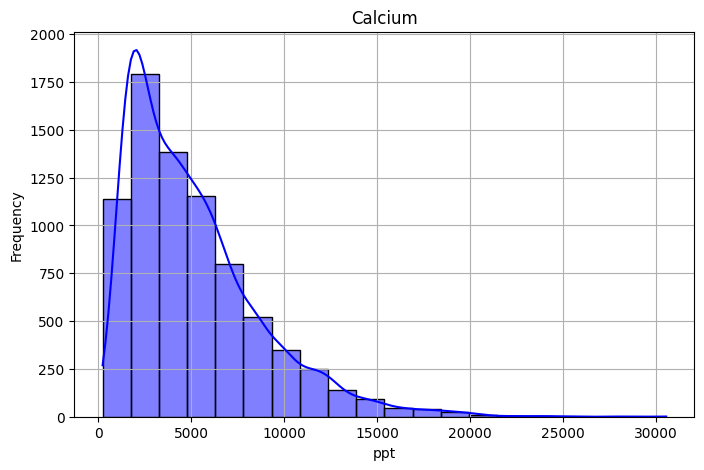

In [16]:

plt.figure(figsize=(8,5))
sns.histplot(train_merged['Ca'], bins=20, kde=True, color="blue")
plt.title("Calcium")
plt.xlabel("ppt")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [18]:
train_merged.isnull().sum()

site           0
PID            0
lon_x          0
lat_x          0
pH             0
              ..
NDWI_gao       0
NDRE_approx    0
EVI            0
SAVI           0
NBR            0
Length: 63, dtype: int64

In [19]:
target_columns = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

In [16]:
test_merged.isnull().sum()

site           0
PID            0
lon_x          0
lat_x          0
pH             0
alb            0
bio1           0
bio12          0
bio15          0
bio7           0
bp             0
cec20          0
dows           0
ecec20         0
hp20           0
ls             0
lstd           0
lstn           0
mb1            0
mb2            0
mb3            0
mb7            0
mdem           0
para           0
parv           0
ph20           0
slope          0
snd20          0
soc20          0
tim            0
wp             0
xhp20          0
BulkDensity    0
QA_PIXEL       0
QA_RADSAT      0
SR_B1          0
SR_B2          0
SR_B3          0
SR_B4          0
SR_B5          0
SR_B6          0
SR_B7          0
ST_B10         0
lat_y          0
lon_y          0
NDVI           0
NDWI_mcf       0
NDWI_gao       0
NDRE_approx    0
EVI            0
SAVI           0
NBR            0
dtype: int64

In [49]:
train_df.tail()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,...,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
7739,site_id_qnYCGg,ID_SL3ETR,70.240079,39.738497,5.4,140,143,1453,66,141,...,2.0,522,1878,305,11.0,124.0,185.0,4.6,2.0,0.39
7740,site_id_qnYCGg,ID_m3eydu,70.241244,39.735097,5.5,141,143,1453,66,141,...,2.0,264,1317,211,12.0,122.0,217.0,5.3,2.5,0.20
7741,site_id_qnYCGg,ID_GGQ39P,70.229183,39.734177,5.5,145,145,1406,65,140,...,3.0,352,1671,228,10.0,142.0,209.0,9.9,2.9,0.30
7742,site_id_qnYCGg,ID_PS0d4J,70.243131,39.756517,5.1,140,142,1420,66,141,...,3.0,366,1507,239,13.0,142.0,264.0,10.0,2.2,0.33
7743,site_id_jfGDPa,ID_IGMXgo,70.238442,39.733527,5.4,145,144,1466,66,140,...,2.0,449,1510,182,14.0,112.0,264.0,4.7,2.3,0.17


In [49]:
test_merged.columns

Index(['site', 'PID', 'lon_x', 'lat_x', 'pH', 'alb', 'bio1', 'bio12', 'bio15',
       'bio7', 'bp', 'cec20', 'dows', 'ecec20', 'hp20', 'ls', 'lstd', 'lstn',
       'mb1', 'mb2', 'mb3', 'mb7', 'mdem', 'para', 'parv', 'ph20', 'slope',
       'snd20', 'soc20', 'tim', 'wp', 'xhp20', 'BulkDensity', 'QA_PIXEL',
       'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6',
       'SR_B7', 'ST_B10', 'lat_y', 'lon_y', 'NDVI', 'NDWI_mcf', 'NDWI_gao',
       'NDRE_approx', 'EVI', 'SAVI', 'NBR'],
      dtype='object')

In [20]:
# Feature selection
X = train_merged.drop(columns=target_columns)
y = train_merged[target_columns]
X_test = test_merged.drop(columns=['PID',"site",'QA_PIXEL',
       'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6',
       'SR_B7', 'ST_B10', 'lat_y', 'lon_y','lon_x', 'lat_x'])

In [21]:
X = X.drop(columns = ['site', 'PID', 'lon_x', 'lat_x','QA_PIXEL',
       'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6',
       'SR_B7', 'ST_B10', 'lat_y', 'lon_y'])

In [23]:
y.shape

7744

In [28]:
len(X.columns)

36

In [55]:
len(X_test.columns)

36

In [34]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train = X_train.drop(columns=['PID','site'])
X_val = X_val.drop(columns=['PID','site'])

In [33]:
len(X_test_selected.columns)

8

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

X_train_scaled_df = pd.DataFrame(X_train_scaled , columns = X_train.columns ,index = X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled , columns = X_val.columns ,index = X_val.index)

In [52]:
from sklearn.decomposition import PCA
# 2. Applying PCA
pca = PCA(n_components=16, random_state=42)
X_pca = pca.fit_transform(X)

# 3. Checking how much variance we're retaining
explained = pca.explained_variance_ratio_.sum()
print(f"Total explained variance by 16 components: {explained:.2f}")

Total explained variance by 16 components: 1.00


In [55]:
test_pca = pca.transform(X_test)

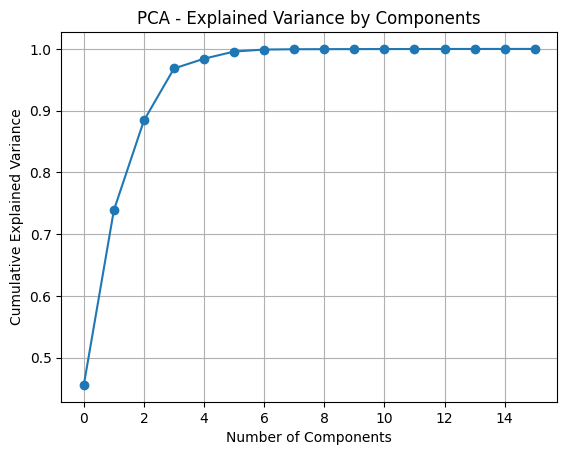

In [54]:
# pca_full = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance by Components')
plt.grid(True)
plt.show()

In [62]:
base_estimator = RandomForestRegressor(n_estimators = 100 ,random_state = 42 ,n_jobs = -1)

final_model = MultiOutputRegressor(base_estimator)
final_model.fit(X_pca,y)


MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))

In [61]:
X_pca.shape

(7744, 16)

In [60]:
test_pca.shape

(2418, 16)

In [64]:
test_preds = final_model.predict(test_pca)

In [65]:
test_preds

array([[1.86100e+03, 2.44425e+01, 1.47070e+02, ..., 1.91520e+00,
        3.69840e+00, 2.15900e-01],
       [1.48940e+03, 1.40605e+01, 2.08050e+02, ..., 2.08400e+00,
        5.28860e+00, 2.51400e-01],
       [1.88420e+03, 1.65488e+01, 2.22260e+02, ..., 1.49760e+00,
        3.91680e+00, 2.03700e-01],
       ...,
       [2.30580e+03, 4.52142e+01, 5.31320e+02, ..., 8.83680e+00,
        3.48010e+00, 7.39800e-01],
       [2.40810e+03, 3.89982e+01, 6.69240e+02, ..., 7.47500e+00,
        4.37040e+00, 1.00370e+00],
       [2.12540e+03, 5.48710e+00, 4.05790e+02, ..., 3.42050e+00,
        1.38060e+00, 3.57800e-01]])

In [66]:
# Split the predictions into separate columns
N_pred =  test_preds[:, 0]  # Predictions for N
P_pred =  test_preds[:, 1]  # Predictions for P
K_pred =  test_preds[:, 2]  # Predictions for K
Ca_pred = test_preds[:, 3]  # Predictions for Ca
Mg_pred = test_preds[:, 4]  # Predictions for Mg
S_pred =  test_preds[:, 5]  # Predictions for S
Fe_pred = test_preds[:, 6]  # Predictions for Fe
Mn_pred = test_preds[:, 7]  # Predictions for Mn
Zn_pred = test_preds[:, 8]  # Predictions for Zn
Cu_pred = test_preds[:, 9]  # Predictions for Cu
B_pred =  test_preds[:, 10]  # Predictions for B

submission = pd.DataFrame({'PID': test_merged['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')

# merging test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')

soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]

nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]

nutrient_df.to_csv('mysubmissionx945amApr25.csv', index=False)


In [29]:
#implementing RFECV on the entire dataset for training using RandomForest model

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

base_estimator = RandomForestRegressor(n_estimators = 100 ,random_state = 42 ,n_jobs = -1)

final_model = MultiOutputRegressor(base_estimator)
selected_features = []

for i in range(y.shape[1]):
    print(f"Running RFE on target {i + 1}")
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    rfecv.fit(X, y.iloc[:, i])
    selected = X.columns[rfecv.support_]
    selected_features.append(set(selected))

# Keep only features selected across all targets (intersection)
final_features = list(set.intersection(*selected_features))
print("Final selected features across all targets:", final_features)

# Train final model with selected features
X_train_rfe = X[final_features]
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train_rfe, y)

Running RFE on target 1
Running RFE on target 2
Running RFE on target 3
Running RFE on target 4
Running RFE on target 5
Running RFE on target 6
Running RFE on target 7
Running RFE on target 8
Running RFE on target 9
Running RFE on target 10
Running RFE on target 11
Final selected features across all targets: ['slope', 'mb7', 'dows', 'mb2', 'pH', 'NBR', 'bio12', 'lstn']


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [54]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled ,columns = X_test.columns , index = X_test.index)

In [66]:
# Predict on validation set
predictions = model.predict(X_test)
y_pred = model.predict(X_val)

In [67]:
# Evaluate model
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

MAE: 162.9987, RMSE: 496.8085


In [68]:
test_predictions = model.predict(X_test)

In [69]:
test_predictions

array([[1.65570e+03, 4.50900e+00, 1.83370e+02, ..., 2.27960e+00,
        3.88310e+00, 2.23500e-01],
       [1.41230e+03, 2.98980e+00, 1.72470e+02, ..., 2.06260e+00,
        4.24070e+00, 1.90600e-01],
       [1.76430e+03, 1.95810e+00, 2.13270e+02, ..., 1.53800e+00,
        3.96270e+00, 2.31200e-01],
       ...,
       [2.72020e+03, 4.68350e+00, 3.27970e+02, ..., 6.79610e+00,
        1.35000e+00, 2.96700e-01],
       [2.44810e+03, 6.51120e+00, 2.82160e+02, ..., 1.28035e+01,
        1.42270e+00, 2.60400e-01],
       [1.80320e+03, 1.69211e+01, 5.00070e+02, ..., 4.23190e+00,
        1.66010e+00, 4.43800e-01]])

In [70]:
# Split the predictions into separate columns
N_pred =  test_predictions[:, 0]  # Predictions for N
P_pred =  test_predictions[:, 1]  # Predictions for P
K_pred =  test_predictions[:, 2]  # Predictions for K
Ca_pred = test_predictions[:, 3]  # Predictions for Ca
Mg_pred = test_predictions[:, 4]  # Predictions for Mg
S_pred =  test_predictions[:, 5]  # Predictions for S
Fe_pred = test_predictions[:, 6]  # Predictions for Fe
Mn_pred = test_predictions[:, 7]  # Predictions for Mn
Zn_pred = test_predictions[:, 8]  # Predictions for Zn
Cu_pred = test_predictions[:, 9]  # Predictions for Cu
B_pred =  test_predictions[:, 10]  # Predictions for B


In [71]:
submission = pd.DataFrame({'PID': test_merged['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission.head()

,PID,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
0,ID_NGS9Bx,1655.7,4.5090,183.37,5376.67,1685.27,10.1358,127.273,155.587,2.2796,3.8831,0.2235
1,ID_YdVKXw,1412.3,2.9898,172.47,6267.40,2226.71,9.9182,124.129,146.740,2.0626,4.2407,0.1906
2,ID_MZAlfE,1764.3,1.9581,213.27,5901.89,1718.91,9.1244,132.081,156.630,1.5380,3.9627,0.2312
3,ID_GwCCMN,1842.8,6.3726,212.86,6219.04,1802.17,8.7974,131.199,168.250,1.9605,3.9417,0.2211
4,ID_K8sowf,1632.9,8.3435,194.38,5398.48,1258.34,8.7487,138.024,135.540,2.0667,3.4500,0.1877


In [72]:
submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')
submission_melted.head()

,PID,Nutrient,Available_Nutrients_in_ppm
19869,ID_002W8m,Zn,2.9393
15033,ID_002W8m,Fe,210.2320
2943,ID_002W8m,P,6.6500
24705,ID_002W8m,B,0.3006
525,ID_002W8m,N,2100.3000


In [73]:
# prompt: merge test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')


In [74]:
soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

In [75]:
nutrient_df.head()

,Nutrient,Required,PID,BulkDensity,Available_Nutrients_in_ppm,Available_Nutrients_in_kg_ha
0,N,100.0,ID_NGS9Bx,1.2,1655.700,3973.6800
1,P,40.0,ID_NGS9Bx,1.2,4.509,10.8216
2,K,52.0,ID_NGS9Bx,1.2,183.370,440.0880
3,Ca,12.0,ID_NGS9Bx,1.2,5376.670,12904.0080
4,Mg,8.0,ID_NGS9Bx,1.2,1685.270,4044.6480


In [76]:
nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]

In [77]:
nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]
nutrient_df.head()

,ID,Gap
0,ID_NGS9Bx_N,-3873.6800
1,ID_NGS9Bx_P,29.1784
2,ID_NGS9Bx_K,-388.0880
3,ID_NGS9Bx_Ca,-12892.0080
4,ID_NGS9Bx_Mg,-4036.6480


In [78]:
nutrient_df.tail()

,ID,Gap
26593,ID_oMn2Yb_Fe,-406.054600
26594,ID_oMn2Yb_Mn,-365.973200
26595,ID_oMn2Yb_Zn,-9.248732
26596,ID_oMn2Yb_Cu,-3.585028
26597,ID_oMn2Yb_B,-0.931864


In [79]:
nutrient_df.to_csv('mysubmissionx23Apr.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [80]:
import optuna
from sklearn.model_selection import cross_val_score

In [93]:
#hyperparameter tuning with  optuna

def objective(trial):
  n_estimators = trial.suggest_int('n_estimators',50,500)
  max_depth = trial.suggest_int('max_depth',3,50)
  min_samples_split = trial.suggest_int('min_samples_split',2,10)
  min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
  max_features = trial.suggest_categorical('max_features',['sqrt' , 'log2', None])
  bootstrap = trial.suggest_categorical('bootstrap',[True,False])

  rf2 = RandomForestRegressor(
      n_estimators = n_estimators,
      max_depth = max_depth,
      min_samples_split = min_samples_split,
      min_samples_leaf = min_samples_leaf,
      max_features = max_features,
      bootstrap = bootstrap,
      random_state = 42,
      n_jobs = - 1
  )

  rf2.fit(X_train , y_train)

  preds = rf2.predict(X_val)

  rmse = np.sqrt(mean_squared_error(y_val, preds))
  return rmse

In [95]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective , n_trials = 150)

[I 2025-04-23 11:43:34,433] A new study created in memory with name: no-name-97bb2fdc-50b1-48f4-995a-02d65a507590
[I 2025-04-23 11:43:36,539] Trial 0 finished with value: 499.1459316635047 and parameters: {'n_estimators': 107, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 499.1459316635047.
[I 2025-04-23 11:43:43,781] Trial 1 finished with value: 586.1397141118526 and parameters: {'n_estimators': 102, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 499.1459316635047.
[I 2025-04-23 11:43:47,607] Trial 2 finished with value: 496.6251909736098 and parameters: {'n_estimators': 315, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 496.6251909736098.
[I 2025-04-23 11:43:51,098] Trial 3 finished with value: 511.3167634980053 and pa

In [96]:
#evaluating the model
best_params = study.best_params
best_params

{'n_estimators': 449,
 'max_depth': 18,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': None,
 'bootstrap': True}

In [30]:
def evaluate_model(i,j):
    mae = mean_absolute_error(i,j)
    mse = np.sqrt(mean_squared_error(i,j))

    return mae , mse

In [98]:
rf_tuned = RandomForestRegressor(**best_params, random_state=42,n_jobs = -1)
rf_tuned.fit(X_train_scaled, y_train)
rf_tuned_preds = rf_tuned.predict(X_val)

evaluate_model(y_val ,rf_tuned_preds)

(164.0625432271777, 477.82546464807467)

In [99]:
test_preds = rf_tuned.predict(X_test)

In [100]:
# Split the predictions into separate columns
N_pred =  test_preds[:, 0]  # Predictions for N
P_pred =  test_preds[:, 1]  # Predictions for P
K_pred =  test_preds[:, 2]  # Predictions for K
Ca_pred = test_preds[:, 3]  # Predictions for Ca
Mg_pred = test_preds[:, 4]  # Predictions for Mg
S_pred =  test_preds[:, 5]  # Predictions for S
Fe_pred = test_preds[:, 6]  # Predictions for Fe
Mn_pred = test_preds[:, 7]  # Predictions for Mn
Zn_pred = test_preds[:, 8]  # Predictions for Zn
Cu_pred = test_preds[:, 9]  # Predictions for Cu
B_pred =  test_preds[:, 10]  # Predictions for B

submission = pd.DataFrame({'PID': test_merged['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')

# merging test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')

soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]

nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]

nutrient_df.to_csv('mysubmissionx342pmApr23.csv', index=False)

In [24]:
from sklearn.svm import SVR

In [25]:

def objective(trial):
    # 1. Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1.0)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])

    # 2. Define and wrap the SVR model
    svr = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model_svr = MultiOutputRegressor(svr, n_jobs=-1)

    # 3. Fit on training data
    model_svr.fit(X_train_scaled_df, y_train)

    # 4. Predict on validation set
    y_pred = model_svr.predict(X_val_scaled_df)

    # 5. Compute RMSE on validation
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2025-04-23 18:24:31,766] A new study created in memory with name: no-name-da5190c8-50e9-4d0e-a548-24a50d0ec1cc
[I 2025-04-23 18:24:46,606] Trial 0 finished with value: 1088.6033716262684 and parameters: {'C': 1.4102477411795769, 'epsilon': 0.2346199952635519, 'kernel': 'poly'}. Best is trial 0 with value: 1088.6033716262684.
[I 2025-04-23 18:25:05,713] Trial 1 finished with value: 1143.4554653021373 and parameters: {'C': 0.016075149545190244, 'epsilon': 0.12517467824244058, 'kernel': 'sigmoid'}. Best is trial 0 with value: 1088.6033716262684.
[I 2025-04-23 18:25:24,784] Trial 2 finished with value: 1099.924740695322 and parameters: {'C': 0.37665057486290143, 'epsilon': 0.526248709943312, 'kernel': 'sigmoid'}. Best is trial 0 with value: 1088.6033716262684.
[I 2025-04-23 18:25:36,962] Trial 3 finished with value: 1139.9476726750136 and parameters: {'C': 0.07927015219068849, 'epsilon': 0.009068723654196134, 'kernel': 'poly'}. Best is trial 0 with value: 1088.6033716262684.
[I 2025-04-

In [27]:
#evaluating the model
best_params = study.best_params
best_params

{'C': 99.61468483207364, 'epsilon': 0.01503979934411302, 'kernel': 'rbf'}

In [31]:
svr_tuned = MultiOutputRegressor(SVR(**best_params))
svr_tuned.fit(X_train_scaled_df, y_train)
svr_tuned_preds = svr_tuned.predict(X_val_scaled_df)

evaluate_model(y_val ,svr_tuned_preds)

(193.98760257480907, 673.5195810283576)

In [112]:
test_preds = svr_tuned.predict(X_test)


In [113]:
# Split the predictions into separate columns
N_pred =  test_preds[:, 0]  # Predictions for N
P_pred =  test_preds[:, 1]  # Predictions for P
K_pred =  test_preds[:, 2]  # Predictions for K
Ca_pred = test_preds[:, 3]  # Predictions for Ca
Mg_pred = test_preds[:, 4]  # Predictions for Mg
S_pred =  test_preds[:, 5]  # Predictions for S
Fe_pred = test_preds[:, 6]  # Predictions for Fe
Mn_pred = test_preds[:, 7]  # Predictions for Mn
Zn_pred = test_preds[:, 8]  # Predictions for Zn
Cu_pred = test_preds[:, 9]  # Predictions for Cu
B_pred =  test_preds[:, 10]  # Predictions for B

submission = pd.DataFrame({'PID': test_merged['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')

# merging test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')

soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]

nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]

nutrient_df.to_csv('mysubmissionx401pmApr23.csv', index=False)

In [32]:
from lightgbm import LGBMRegressor
def objective(trial):
    # Suggest LightGBM hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    # Define LightGBM model and wrap for multi-output
    lgb_model = MultiOutputRegressor(LGBMRegressor(**params), n_jobs=-1)

    # Fit and evaluate
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    return rmse

In [33]:
# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Best result
print(" Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-04-23 19:25:12,394] A new study created in memory with name: no-name-5b142117-8b16-4f54-a401-a0f2a585d9c0


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7968
[LightGBM] [Info] Number of data points in the train set: 6195, number of used features: 36
[LightGBM] [Info] Start training from score 5095.017433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-04-23 19:52:08,677] Trial 0 finished with value: 236.40856441184124 and parameters: {'n_estimators': 483, 'max_depth': 7, 'learning_rate': 0.024649832054333798, 'num_leaves': 153, 'subsample': 0.8551946015768518, 'colsample_bytree': 0.5084573976474641, 'reg_alpha': 0.6275152023496688, 'reg_lambda': 7.6715162078521075}. Best is trial 0 with value: 236.40856441184124.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-04-23 20:22:57,463] Trial 1 finished with value: 364.8981026079925 and parameters: {'n_estimators': 497, 'max_depth': 6, 'learning_rate': 0.0010914132808973666, 'num_leaves': 158, 'subsample': 0.931005023414323, 'colsample_bytree': 0.7710601181657503, 'reg_alpha': 0.0013501850613768535, 'reg_lambda': 0.014038178853012725}. Best is trial 0 with value: 236.40856441184124.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-04-23 20:37:49,025] Trial 2 finished with value: 240.02940232620196 and parameters: {'n_estimators': 356, 'max_depth': 6, 'learning_rate': 0.01465947260164538, 'num_leaves': 115, 'subsample': 0.5356222030339011, 'colsample_bytree': 0.5505732489375412, 'reg_alpha': 0.0019913509268621263, 'reg_lambda': 0.05883761823176826}. Best is trial 0 with value: 236.40856441184124.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-04-23 21:05:46,797] Trial 3 finished with value: 389.1161880252259 and parameters: {'n_estimators': 296, 'max_depth': 7, 'learning_rate': 0.001270491731227227, 'num_leaves': 97, 'subsample': 0.6908846107518134, 'colsample_bytree': 0.859631352694471, 'reg_alpha': 0.6659999372107531, 'reg_lambda': 0.9512231737641783}. Best is trial 0 with value: 236.40856441184124.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-04-23 21:07:26,640] Trial 4 finished with value: 399.3042618245186 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.0033360560898378633, 'num_leaves': 28, 'subsample': 0.6354018959317304, 'colsample_bytree': 0.9941620853095751, 'reg_alpha': 0.44296949131479557, 'reg_lambda': 0.03884863927089079}. Best is trial 0 with value: 236.40856441184124.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[W 2025-04-23 21:21:04,921] Trial 5 failed with parameters: {'n_estimators': 153, 'max_depth': 10, 'learning_rate': 0.004997587465506491, 'num_leaves': 179, 'subsample': 0.6591535203302531, 'colsample_bytree': 0.734396230369798, 'reg_alpha': 0.012856093031100208, 'reg_lambda': 0.0032370611318701045} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_31/3444244713.py", line 21, in objective
    lgb_model.fit(X_train, y_train)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)


KeyboardInterrupt: 

In [40]:

# Best Optuna hyperparameters from Trial 0
best_params = {
    'n_estimators': 483,
    'max_depth': 7,
    'learning_rate': 0.024649832054333798,
    'num_leaves': 153,
    'subsample': 0.8551946015768518,
    'colsample_bytree': 0.5084573976474641,
    'reg_alpha': 0.6275152023496688,
    'reg_lambda': 7.6715162078521075,
    'random_state': 42,
    'n_jobs': -1
}

# MultiOutput wrapper for LightGBM
final_model = MultiOutputRegressor(LGBMRegressor(**best_params), n_jobs=-1)

# Train the model
final_model.fit(X, y)

# # Predict on validation set
# y_pred = final_model.predict(X_val)

# # Evaluate
# rmse = mean_squared_error(y_val, y_pred, squared=False)
# print(f"Final RMSE on validation set: {rmse:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8009
[LightGBM] [Info] Number of data points in the train set: 7744, number of used features: 36
[LightGBM] [Info] Start training from score 15.593426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.5084573976474641,
                                             learning_rate=0.024649832054333798,
                                             max_depth=7, n_estimators=483,
                                             n_jobs=-1, num_leaves=153,
                                             random_state=42,
                                             reg_alpha=0.6275152023496688,
                                             reg_lambda=7.6715162078521075,
                                             subsample=0.8551946015768518),
                     n_jobs=-1)

In [41]:
test_preds = final_model.predict(X_test)


In [36]:
light_preds = final_model.predict(X_val)

In [37]:
evaluate_model(y_val , light_preds)

(158.22319591695398, 468.4269920573585)

In [42]:
# Split the predictions into separate columns
N_pred =  test_preds[:, 0]  # Predictions for N
P_pred =  test_preds[:, 1]  # Predictions for P
K_pred =  test_preds[:, 2]  # Predictions for K
Ca_pred = test_preds[:, 3]  # Predictions for Ca
Mg_pred = test_preds[:, 4]  # Predictions for Mg
S_pred =  test_preds[:, 5]  # Predictions for S
Fe_pred = test_preds[:, 6]  # Predictions for Fe
Mn_pred = test_preds[:, 7]  # Predictions for Mn
Zn_pred = test_preds[:, 8]  # Predictions for Zn
Cu_pred = test_preds[:, 9]  # Predictions for Cu
B_pred =  test_preds[:, 10]  # Predictions for B

submission = pd.DataFrame({'PID': test_merged['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')

# merging test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')

soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]

nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]

nutrient_df.to_csv('mysubmissionx115amApr24.csv', index=False)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 